In [1]:
%%capture
!pip install langchain_core langchain langchain_community langgraph langchain-google-genai

In [ ]:
import os


os.environ["GOOGLE_API_KEY"]=google_api_key

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm=ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    temperature=0
    )

In [5]:
from langgraph.graph import START,END,StateGraph
from typing_extensions import TypedDict
from typing import List,Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

In [6]:
class ChatState(TypedDict):
  messages:Annotated[List[str],add_messages]


In [7]:
from langchain_community.tools import TavilySearchResults


In [9]:
from langchain_core.tools import tool
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [10]:
tool = TavilySearchResults(max_results=2)
tools=[tool,human_assistance]

/tmp/ipython-input-2114295455.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [39]:
tool.invoke("langgraph agent")

[{'title': 'What is LangGraph?',
  'url': 'https://www.ibm.com/think/topics/langgraph',
  'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.\n\nLLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegian Cruise Line uses LangGraph to compile, construct and refine guest-facing AI solutions. This capability allows

In [11]:
from langgraph.types import Command,interrupt
from langgraph.prebuilt import ToolNode,tools_condition

In [12]:
llm_with_tool=llm.bind_tools(tools)

In [13]:
workflow=StateGraph(ChatState)

In [14]:
def chat_node(state:ChatState):
  user_input=state['messages']
  bot_response=llm_with_tool.invoke(user_input)
  assert len(bot_response.tool_calls)<=1

  return {"messages":[bot_response]}

In [15]:
tool_node=ToolNode(tools=tools)

In [16]:
workflow.add_node("chat_node",chat_node)
workflow.add_node("tools",tool_node)

In [17]:


workflow.add_conditional_edges(
    "chat_node",
    tools_condition

)
workflow.add_edge("tools","chat_node")
workflow.add_edge(START,"chat_node")

In [18]:
# workflow.add_edge(START,"chat_node")

# workflow.add_conditional_edges(
#     "chat_node",
#     tools_condition

# )
# workflow.add_edge("tools","chat_node")

In [19]:
checkpointer=InMemorySaver()

In [20]:
app=workflow.compile(checkpointer=checkpointer)

In [ ]:
thread_id="1"
config={"configurable":{"thread_id":thread_id}}
response=app.invoke({"message":["capital of india ?"]},config=config)
response

{'message': [HumanMessage(content='capital of india ?', additional_kwargs={}, response_metadata={}, id='4740ddb4-e3e2-4791-aeea-b8d3e99d36a2'),
  AIMessage(content='The capital of India is **New Delhi**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []}, id='run--0af84277-45ac-4294-b43d-a3c1b1e203dd-0', usage_metadata={'input_tokens': 4, 'output_tokens': 10, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})]}

In [ ]:
response['message'][-1].content

'The capital of India is **New Delhi**.'

In [ ]:
print("Welcome \n enter ' q ' to exit")
while(1):
  user_message=input("enter : ")

  if user_message == "q":
    print("Thank you...\n quiting...")
    break

  response=app.invoke({"message":[user_message]},config=config)
  print(f"Bot : {response['message'][-1].content}")

Welcome 
 enter ' q ' to exit
enter : q
Thank you...
 quiting...


In [21]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
res=llm_with_tool.invoke(user_input)

In [25]:
res.additional_kwargs

{'function_call': {'name': 'human_assistance',
  'arguments': '{"query": "I need some expert guidance for building an AI agent."}'}}

In [24]:
res.content

''

In [26]:
res

AIMessage(content='', additional_kwargs={'function_call': {'name': 'human_assistance', 'arguments': '{"query": "I need some expert guidance for building an AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []}, id='run--38ec950a-d53a-40d8-8191-3ef0c7e495e3-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need some expert guidance for building an AI agent.'}, 'id': '893b5a62-4af2-4362-9b60-ea52f5c14070', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 15, 'total_tokens': 95, 'input_token_details': {'cache_read': 0}})

In [22]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
events = app.stream(
    {"messages":[user_input]},
    config,
    stream_mode="values",
)

In [23]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (42d25aa0-f964-44bb-8cab-5fe57a51bc4b)
 Call ID: 42d25aa0-f964-44bb-8cab-5fe57a51bc4b
  Args:
    query: I need some expert guidance for building an AI agent.


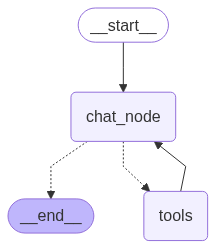

In [29]:
app

In [24]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

In [25]:
human_command=Command(resume={"data": human_response})

In [26]:
events=app.stream(
    human_command,
    config,
    stream_mode="values"
)

In [27]:
for event in events:
  if "messages" in event:
     event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (42d25aa0-f964-44bb-8cab-5fe57a51bc4b)
 Call ID: 42d25aa0-f964-44bb-8cab-5fe57a51bc4b
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

OK. I've requested assistance from a human expert.  They suggest checking out LangGraph for building an AI agent, as it's more reliable and extensible than simpler approaches.


In [33]:
human_response = (
"""Maybe I'll build an autonomous agent with langraph.
"""
)
human_command=Command(resume={"data": human_response})
events=app.stream(
    human_command,
    config,
    stream_mode="values"
)


In [32]:
for event in events:
  if "messages" in event:
     event['messages'][-1].pretty_print()

================================== Ai Message ==================================

OK. I've requested assistance from a human expert.  They suggest checking out LangGraph for building an AI agent, as it's more reliable and extensible than simpler approaches.


In [37]:
user_input = "I'm learning LangGraph. Could you do some research on it for me? use tavily tool"
config = {"configurable": {"thread_id": "1"}}
events = app.stream(
    {"messages":[user_input]},
    config,
    stream_mode="values",
)
for event in events:
  if "messages" in event:
     event['messages'][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me? use tavily tool
================================== Ai Message ==================================

I cannot directly use the `tavily_search_results_json` function to search for information on LangGraph because I don't have access to a real search engine.  The function is a placeholder; it doesn't actually perform a search.  To get information on LangGraph, you will need to perform the search yourself using a search engine like Google, Bing, or DuckDuckGo.

If you have specific questions about LangGraph after doing your own research, I can help you understand the answers or help you formulate more effective search queries.


In [38]:
user_input = "do tavily search for indian PM "
config = {"configurable": {"thread_id": "1"}}
events = app.stream(
    {"messages":[user_input]},
    config,
    stream_mode="values",
)
for event in events:
  if "messages" in event:
     event['messages'][-1].pretty_print()

================================ Human Message =================================

do tavily search for indian PM 
================================== Ai Message ==================================

I cannot directly use the `tavily_search_results_json` function because it's a placeholder and doesn't connect to a real search engine.  To find information about the Indian Prime Minister, you should use a search engine like Google, Bing, or DuckDuckGo.  Just search for "Indian Prime Minister".
